# Filter Citrus RNA dataset

WIP: Filtering citrus RNA dataset based on missing values in relevant columns and marking missing data to use in the LLM step.  
TODO: Filter citrus DNA dataset in a similar way.

In [115]:
import pandas as pd
pd.set_option('display.max_rows', None)
import missingno as msno
import regex as re

In [116]:
# Helper functions
def missing_values_table(df: pd.DataFrame) -> pd.DataFrame:
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

def drop_columns_with_missing(df: pd.DataFrame, columns_to_keep: list | None = None, threshold: float =  0.1):
    """
    Drop columns that do not meet the non-NA threshold (as a fraction of total rows),
    like df.dropna(axis=1, thresh=int(threshold * len(df))),
    but always keep columns listed in columns_to_keep.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        columns_to_keep (list, optional): Columns that should never be dropped.
        threshold (float): Minimum fraction of non-NA values required to keep a column.
                           For example, 0.1 means at least 10% non-missing values.

    Returns:
        pd.DataFrame: DataFrame with selected columns dropped.
    """
    if columns_to_keep is None:
        columns_to_keep = []

    # Compute minimum count of non-missing values required
    min_non_na = int(threshold * len(df))

    # Identify columns that would be dropped by dropna with that threshold
    to_drop = df.columns[df.notna().sum() < min_non_na]

    # Exclude columns to keep
    to_drop = [col for col in to_drop if col not in columns_to_keep]

    # Drop them
    return df.drop(columns=to_drop)

# List of text patterns meaning "missing"
missing_patterns = [
    'not applicable', 'not applicale', 'missing', 'not collected',
    'uncalculated', 'na', 'n/a', 'nan'
]

# Compile regex, matching even with punctuation or spacing variations
pattern = re.compile(r'\b(' + '|'.join(missing_patterns) + r')\b', flags=re.IGNORECASE)

# Function to detect missing/invalid entries
def has_missing_value(cell: pd.Series | str | float | None) -> bool:
    # If NaN or None
    if pd.isna(cell):
        return True
    # Normalize string
    cell_str = str(cell).strip().lower()
    # Empty after stripping
    if cell_str == '' or cell_str == 'none':
        return True
    
    # Split by '|' and check each part
    parts = [p.strip() for p in cell_str.split('|') if p.strip() != '']
    # If there are no valid parts, consider it missing
    if len(parts) == 0:
        return True
    
    # Check if any part matches a missing pattern (allow punctuation)
    for part in parts:
        # Remove trailing punctuation
        cleaned = re.sub(r'[^\w\s]', '', part)
        if pattern.search(cleaned):
            return True
    
    return False

In [117]:
citrus_rna_df = pd.read_csv('../data/citrus_rna_filtered.csv',
                               header=0, low_memory=False)
print("Sugarcana - RNA | shape:", citrus_rna_df.shape)
citrus_dna_df = pd.read_csv('../data/citrus_dna_filtered.csv',
                               header=0, low_memory=False)
print("Sugarcana - DNA | shape:", citrus_dna_df.shape)

Sugarcana - RNA | shape: (5634, 164)
Sugarcana - DNA | shape: (5406, 164)


In [118]:
citrus_rna_df.head(3)

,Run,Assay Type,AvgSpotLen,Bases,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,...,scholar_max_citations,scholar_top_article,scholar_processed,scholar_timestamp,scholar_links,doi_count,doi_results,failed_links,success_rate,RunCount
0,SRR13434399,RNA-Seq,300,6716361300,SAMN17311257,2255768940,HUAZHONG AGRICULTURAL UNIVERSITY,public,"fastq,run.zq,sra","gs,ncbi,s3",...,11,Multi‐omics analyses reveal the importance of ...,True,2025-09-03T10:05:12.167768,['https://link.springer.com/article/10.1186/s1...,2.0,"[{""link"": ""https://link.springer.com/article/1...",NaN,1.0,15
1,SRR13434400,RNA-Seq,300,6834424800,SAMN17311256,2293715903,HUAZHONG AGRICULTURAL UNIVERSITY,public,"fastq,run.zq,sra","gs,ncbi,s3",...,11,Multi‐omics analyses reveal the importance of ...,True,2025-09-03T10:05:12.167768,['https://link.springer.com/article/10.1186/s1...,2.0,"[{""link"": ""https://link.springer.com/article/1...",NaN,1.0,15
2,SRR13434401,RNA-Seq,300,6526234500,SAMN17311255,2175705518,HUAZHONG AGRICULTURAL UNIVERSITY,public,"fastq,run.zq,sra","gs,ncbi,s3",...,11,Multi‐omics analyses reveal the importance of ...,True,2025-09-03T10:05:12.167768,['https://link.springer.com/article/10.1186/s1...,2.0,"[{""link"": ""https://link.springer.com/article/1...",NaN,1.0,15


In [119]:
# Remove columns that are completely empty
citrus_rna_df = citrus_rna_df.dropna(axis=1, how='all')
# Just for RNA for now
# citrus_dna_df = citrus_dna_df.dropna(axis=1, how='all') 

In [120]:
# Columns to always keep due to their importance in the analysis
columns_to_keep = ['geographic_location_(longitude)', 'geographic_location_(latitude)', 'lat_lon', 'treatment', 'replicate', 'genotype', 'tissue', 'Cultivar',
                   'geo_loc_name', 'geo_loc_name_country', 'geo_loc_name_country_continent', 'geographic_location_(latitude)', 'geographic_location_(longitude)',
                   'isolation_and_growth_condition', 'plant_growth_medium',
                   'dev_stage', 'AGE', 'isolate', 'plant_structure', 'plant_developmental_stage', 'PMIDs', 'isol_growth_condt', 'isolation_source', 
                   'isol_growth_condt', 'Developmental_stage', 'Biological_Replicate', 'disease_stage', 'disease', 'infected_with', 'Development_stage']
citrus_rna_df = drop_columns_with_missing(citrus_rna_df, columns_to_keep)
# citrus_dna_df = drop_columns_with_missing(citrus_dna_df, columns_to_keep)

<Axes: >

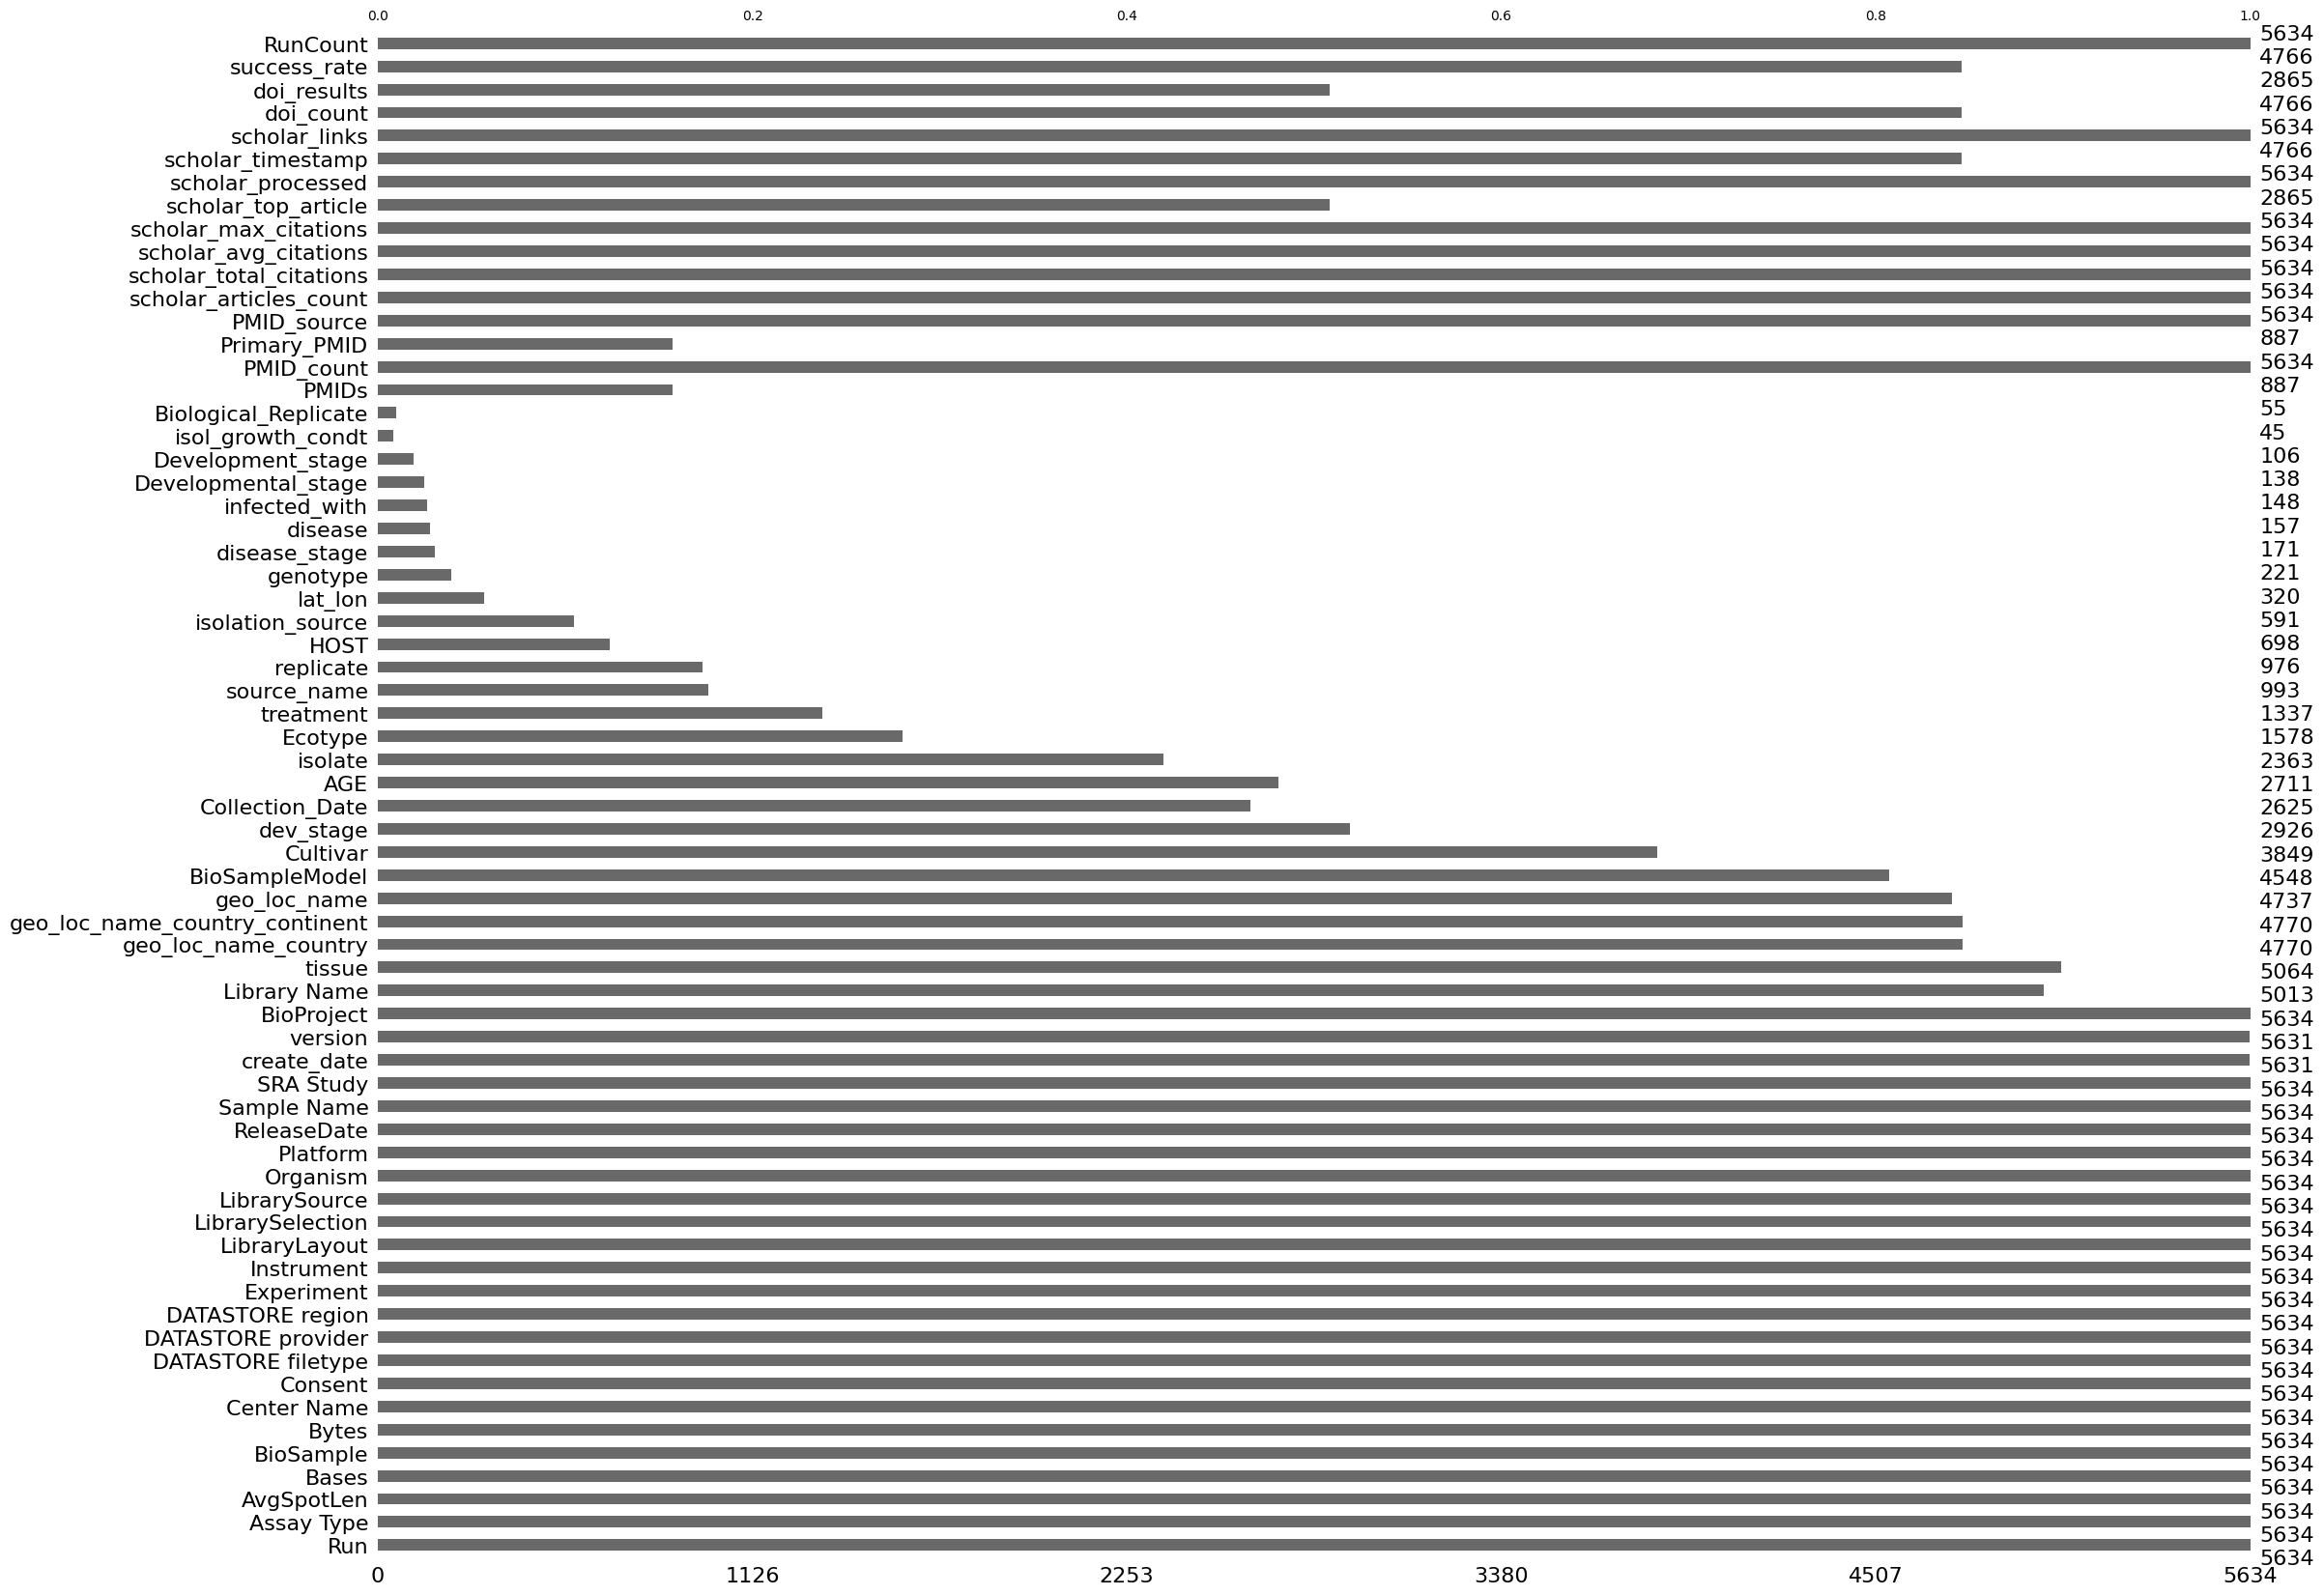

In [121]:
msno.bar(citrus_rna_df)

In [122]:
# Verify the cultivars present in the dataset
print(citrus_rna_df['Organism'].value_counts())

Organism
Citrus sinensis                                          1575
Citrus                                                    713
Citrus reticulata                                         535
Citrus maxima                                             442
Citrus x limon                                            218
Citrus trifoliata                                         184
Diaphorina citri                                          156
Alternaria alternata                                      117
Citrus hindsii                                            114
Citrus x clementina                                        93
Citrus x paradisi                                          83
Citrus sp.                                                 72
mouse gut metagenome                                       68
Olea europaea                                              60
Bactrocera dorsalis                                        54
viral metagenome                                           54

In [123]:
# Remove rows with non citrus organism entries (based in the previous output)
non_citrus_values = ['Diaphorina citri', 'Alternaria alternata', 'mouse gut metagenome', 'Olea europaea', 'Bactrocera dorsalis', 'viral metagenome', 'Olea europaea subsp. europaea', 'Eriobotrya japonica', 'Colletotrichum gloeosporioides', 'Mus musculus', 'Bactrocera minax', 'Porphyromonas gingivalis', 'Zanthoxylum armatum', 'Diaprepes abbreviatus', 'Penicillium italicum', 'plant metagenome',
                     'Fusarium graminearum', 'Geotrichum citri-aurantii', 'Homalodisca vitripennis', 'Xylella fastidiosa', 'Penicillium digitatum', 'Thaumatotibia leucotreta',
                     'Cuscuta australis', 'rhizosphere metagenome', 'Bactrocera correcta', 'Neoseiulus barkeri', 'Solanum lycopersicum', 'Bacteroides xylanisolvens', 'Anoplophora chinensis',
                     'Geminiviridae sp.', 'Citrus tristeza virus', 'Citrus dwarfing viroid', 'Phytophthora nicotianae', 'synthetic construct', 'Methylobacterium mesophilicum', 'prokaryote coculture', 
                     'Clausena lansium', 'Murraya koenigii', 'Clausena anisata', 'Naringi crenulata']
citrus_rna_df = citrus_rna_df[~citrus_rna_df['Organism'].isin(non_citrus_values)]
print(citrus_rna_df['Organism'].value_counts())

Organism
Citrus sinensis                                          1575
Citrus                                                    713
Citrus reticulata                                         535
Citrus maxima                                             442
Citrus x limon                                            218
Citrus trifoliata                                         184
Citrus hindsii                                            114
Citrus x clementina                                        93
Citrus x paradisi                                          83
Citrus sp.                                                 72
Citrus medica                                              47
Citrus unshiu                                              45
Panonychus citri                                           43
Citrus sinensis x Citrus trifoliata                        42
Citrus reticulata x Citrus trifoliata                      36
Citrus junos                                               36

In [124]:
citrus_rna_df.shape

(4643, 66)

#### Creating the dataframe with only relevant columns

In [125]:
citrus_rna_df.columns

Index(['Run', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioSample', 'Bytes',
       'Center Name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider',
       'DATASTORE region', 'Experiment', 'Instrument', 'LibraryLayout',
       'LibrarySelection', 'LibrarySource', 'Organism', 'Platform',
       'ReleaseDate', 'Sample Name', 'SRA Study', 'create_date', 'version',
       'BioProject', 'Library Name', 'tissue', 'geo_loc_name_country',
       'geo_loc_name_country_continent', 'geo_loc_name', 'BioSampleModel',
       'Cultivar', 'dev_stage', 'Collection_Date', 'AGE', 'isolate', 'Ecotype',
       'treatment', 'source_name', 'replicate', 'HOST', 'isolation_source',
       'lat_lon', 'genotype', 'disease_stage', 'disease', 'infected_with',
       'Developmental_stage', 'Development_stage', 'isol_growth_condt',
       'Biological_Replicate', 'PMIDs', 'PMID_count', 'Primary_PMID',
       'PMID_source', 'scholar_articles_count', 'scholar_total_citations',
       'scholar_avg_citations', 'scholar

In [126]:
# Select the columns
columns = ['Run', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample',
       'Bytes', 'Center Name', 'Consent', 'DATASTORE filetype',
       'DATASTORE provider', 'DATASTORE region', 'Experiment', 'Instrument',
       'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism',
       'Platform', 'ReleaseDate', 'Sample Name', 'SRA Study', 'create_date',
       'version', 'BioSampleModel',  'Collection_Date', 'doi_results', 'PMIDs', 'RunCount']
 
new_columns = ['geo_location', 'growth_conditions', 'sample_conditions', 'genotype', 'replicate']
# Create a dataframe with only relevant columns
citrus_rna_df_relevant = citrus_rna_df[columns]

In [127]:
cols_replic = [
    'replicate', 'Biological_Replicate'
]

# cria nova coluna concatenando valores não nulos separados por "| "
citrus_rna_df_relevant = citrus_rna_df_relevant.copy()

citrus_rna_df_relevant.loc[:, 'replicate'] = (
    citrus_rna_df[cols_replic]
    .astype(str)
    .replace(['nan', 'None', 'NaN'], '')
    .agg('| '.join, axis=1)
    .str.strip('| ')
    .str.replace(r'\s*\|\s*$', '', regex=True)
)

citrus_rna_df_relevant.loc[:, 'replicate'] = (
    citrus_rna_df_relevant['replicate']
    .replace('', pd.NA)
)

In [128]:
cols_geo = [
    'lat_lon',
    'geo_loc_name',
    'geo_loc_name_country',
    'geo_loc_name_country_continent',
]

# cria nova coluna concatenando valores não nulos separados por "| "
citrus_rna_df_relevant = citrus_rna_df_relevant.copy()

citrus_rna_df_relevant.loc[:, 'geo_location'] = (
    citrus_rna_df[cols_geo]
    .astype(str)
    .replace(['nan', 'None', 'NaN'], '')
    .agg('| '.join, axis=1)
    .str.strip('| ')
    .str.replace(r'\s*\|\s*$', '', regex=True)
)

citrus_rna_df_relevant.loc[:, 'geo_location'] = (
    citrus_rna_df_relevant['geo_location']
    .replace('', pd.NA)
)

In [129]:
cols_cndt = [
    'isol_growth_condt',
    'isolation_source'
]

# cria nova coluna concatenando valores não nulos separados por "| "
citrus_rna_df_relevant = citrus_rna_df_relevant.copy()

citrus_rna_df_relevant.loc[:, 'growth_conditions'] = (
    citrus_rna_df[cols_cndt]
    .astype(str)
    .replace(['nan', 'None', 'NaN'], '')
    .agg('| '.join, axis=1)
    .str.strip('| ')
    .str.replace(r'\s*\|\s*$', '', regex=True)
)

citrus_rna_df_relevant.loc[:, 'growth_conditions'] = (
    citrus_rna_df_relevant['growth_conditions']
    .replace('', pd.NA)
)

In [130]:
cols_treatm = [
    'treatment', 'tissue', 'dev_stage', 'AGE', 'isolate', 'Developmental_stage', 'disease_stage', 'disease', 'infected_with', 'Development_stage']

# cria nova coluna concatenando valores não nulos separados por "| "
citrus_rna_df_relevant = citrus_rna_df_relevant.copy()

citrus_rna_df_relevant.loc[:, 'sample_conditions'] = (
    citrus_rna_df[cols_treatm]
    .astype(str)
    .replace(['nan', 'None', 'NaN'], '')
    .agg('| '.join, axis=1)
    .str.strip('| ')
    .str.replace(r'\s*\|\s*$', '', regex=True)
)

citrus_rna_df_relevant.loc[:, 'sample_conditions'] = (
    citrus_rna_df_relevant['sample_conditions']
    .replace('', pd.NA)
)

In [131]:
cols_genotype = ['genotype', 'Cultivar']

# cria nova coluna concatenando valores não nulos separados por "| "
citrus_rna_df_relevant = citrus_rna_df_relevant.copy()

citrus_rna_df_relevant.loc[:, 'genotype'] = (
    citrus_rna_df[cols_genotype]
    .astype(str)
    .replace(['nan', 'None', 'NaN'], '')
    .agg('| '.join, axis=1)
    .str.strip('| ')
    .str.replace(r'\s*\|\s*$', '', regex=True)
)

citrus_rna_df_relevant.loc[:, 'genotype'] = (
    citrus_rna_df_relevant['genotype']
    .replace('', pd.NA)
)

In [132]:
citrus_rna_df_relevant.head(3)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,BioSampleModel,Collection_Date,doi_results,PMIDs,RunCount,replicate,geo_location,growth_conditions,sample_conditions,genotype
0,SRR13434399,RNA-Seq,300,6716361300,PRJNA691971,SAMN17311257,2255768940,HUAZHONG AGRICULTURAL UNIVERSITY,public,"fastq,run.zq,sra",...,Plant,NaN,"[{""link"": ""https://link.springer.com/article/1...",NaN,15,biological replicate 1,China: Hubei Province| China| Asia,<NA>,pulp| 200 days after flowering (DAF)| not coll...,Newhall
1,SRR13434400,RNA-Seq,300,6834424800,PRJNA691971,SAMN17311256,2293715903,HUAZHONG AGRICULTURAL UNIVERSITY,public,"fastq,run.zq,sra",...,Plant,NaN,"[{""link"": ""https://link.springer.com/article/1...",NaN,15,biological replicate 3,China: Hubei Province| China| Asia,<NA>,pulp| 150 days after flowering (DAF)| not coll...,Newhall
2,SRR13434401,RNA-Seq,300,6526234500,PRJNA691971,SAMN17311255,2175705518,HUAZHONG AGRICULTURAL UNIVERSITY,public,"fastq,run.zq,sra",...,Plant,NaN,"[{""link"": ""https://link.springer.com/article/1...",NaN,15,biological replicate 2,China: Hubei Province| China| Asia,<NA>,pulp| 150 days after flowering (DAF)| not coll...,Newhall


<Axes: >

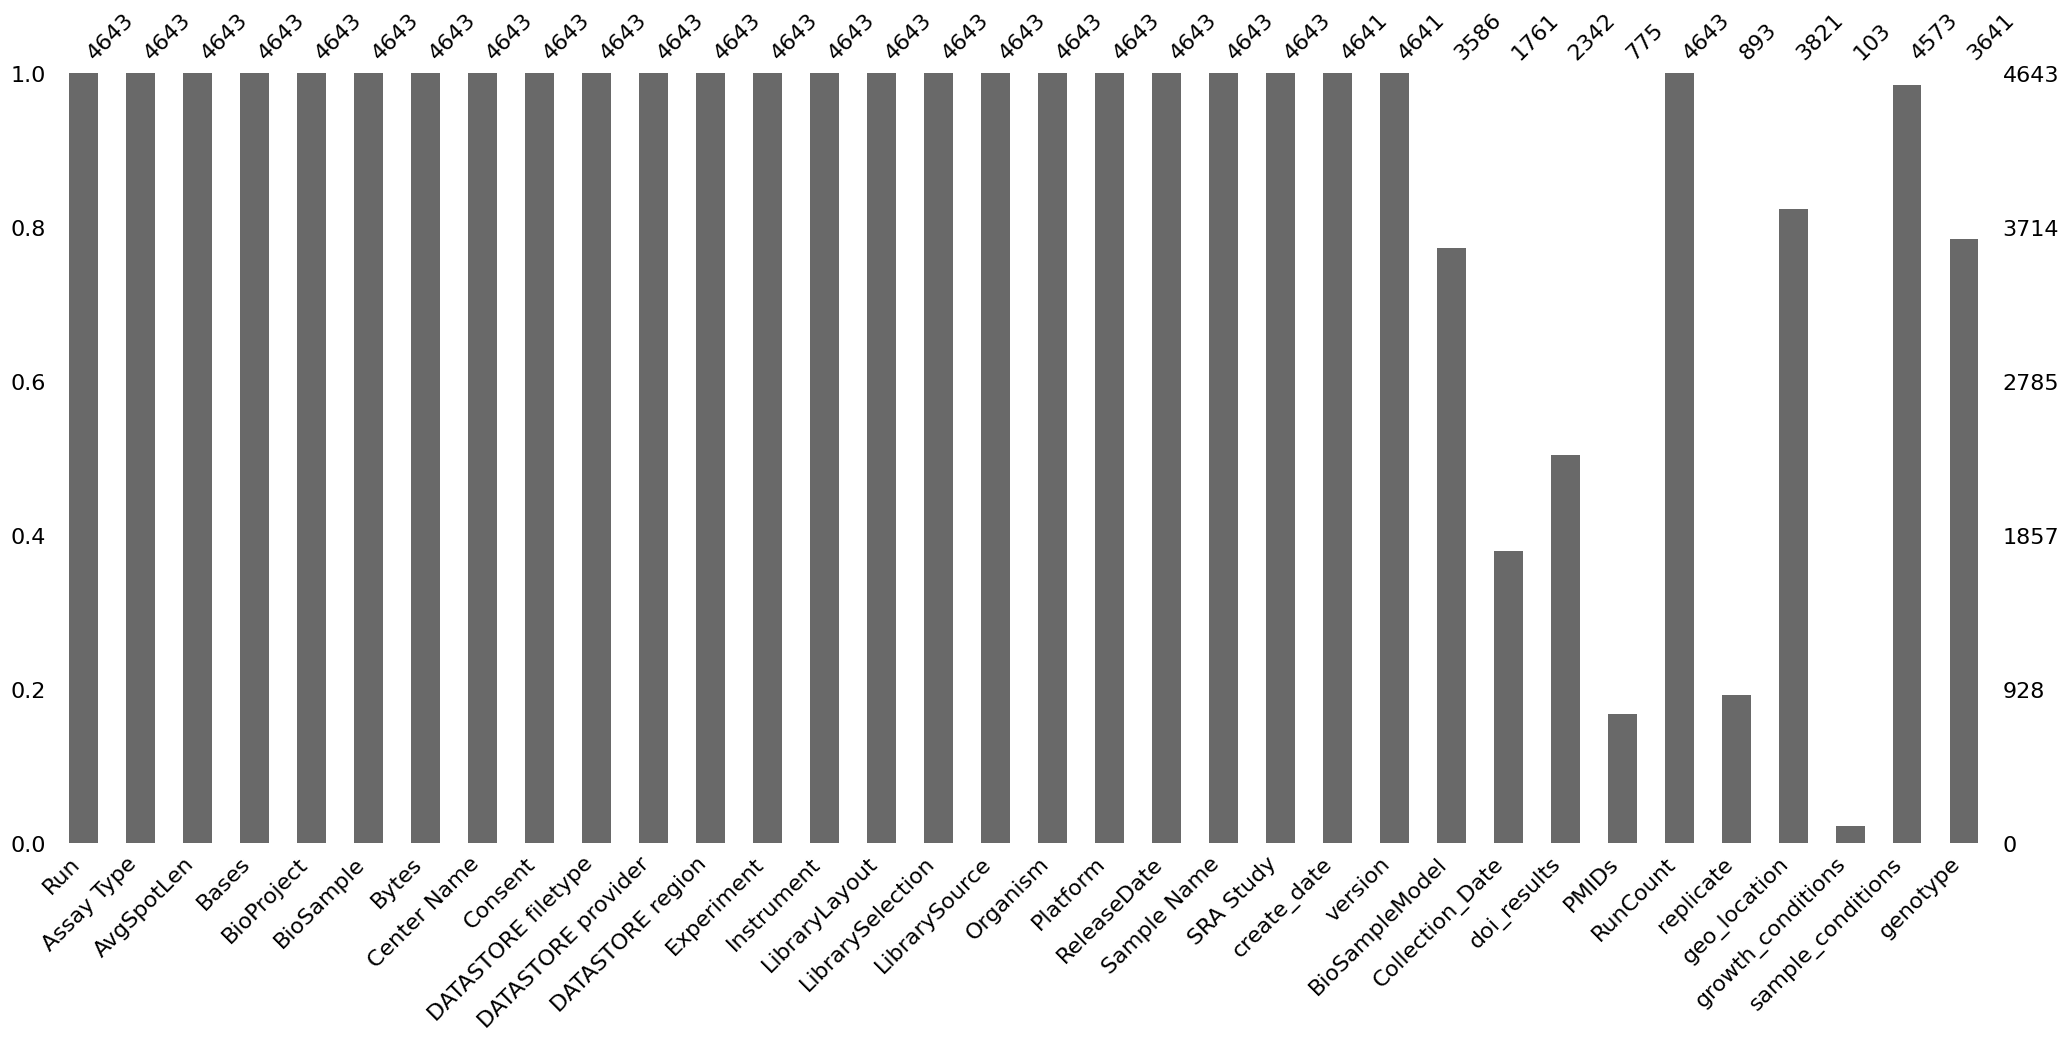

In [133]:
msno.bar(citrus_rna_df_relevant)

In [134]:
for col in ['geo_location', 'growth_conditions', 'sample_conditions', 'genotype', 'replicate']:
    citrus_rna_df_relevant[f'{col}_missing'] = citrus_rna_df_relevant[col].apply(has_missing_value)

In [135]:
citrus_rna_df_relevant.head(3)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,replicate,geo_location,growth_conditions,sample_conditions,genotype,geo_location_missing,growth_conditions_missing,sample_conditions_missing,genotype_missing,replicate_missing
0,SRR13434399,RNA-Seq,300,6716361300,PRJNA691971,SAMN17311257,2255768940,HUAZHONG AGRICULTURAL UNIVERSITY,public,"fastq,run.zq,sra",...,biological replicate 1,China: Hubei Province| China| Asia,<NA>,pulp| 200 days after flowering (DAF)| not coll...,Newhall,False,True,False,False,False
1,SRR13434400,RNA-Seq,300,6834424800,PRJNA691971,SAMN17311256,2293715903,HUAZHONG AGRICULTURAL UNIVERSITY,public,"fastq,run.zq,sra",...,biological replicate 3,China: Hubei Province| China| Asia,<NA>,pulp| 150 days after flowering (DAF)| not coll...,Newhall,False,True,False,False,False
2,SRR13434401,RNA-Seq,300,6526234500,PRJNA691971,SAMN17311255,2175705518,HUAZHONG AGRICULTURAL UNIVERSITY,public,"fastq,run.zq,sra",...,biological replicate 2,China: Hubei Province| China| Asia,<NA>,pulp| 150 days after flowering (DAF)| not coll...,Newhall,False,True,False,False,False


In [136]:
citrus_rna_df_relevant.to_csv('../data/citrus_rna_relevant_filtered.csv', index=False)